In [1]:
# standard python utilities
import os
from os.path import basename, dirname, join, exists
import sys
from importlib import reload
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator

# import flopy
# import flopy.utils.binaryfile as bf


In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)

git_dir = join(doc_dir, 'GitHub')
## Set up directory referencing
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'

bas_dir = join(gwfm_dir, 'BAS6')
proj_dir = join(gwfm_dir,'Levee_setback')
plt_dir = join(proj_dir,'figures/')


In [12]:
def add_path(fxn_dir):
    """ Insert fxn directory into first position on path so local functions supercede the global"""
    if fxn_dir not in sys.path:
        sys.path.insert(0, fxn_dir)
# flopy github path - edited
add_path(doc_dir+'/GitHub/flopy')
import flopy 

# other functions
py_dir = join(doc_dir,'GitHub/CosumnesRiverRecharge/python_utilities')
add_path(py_dir)

# from mf_utility import get_layer_from_elev
# from map_cln import gdf_bnds, plt_cln

In [3]:
# run_dir = 'C://WRDAPP/GWFlowModel'
run_dir = 'F://WRDAPP/GWFlowModel'
loadpth = run_dir +'/Cosumnes/Regional/'

model_nam = 'historical_simple_geology'


model_ws = loadpth+model_nam


In [4]:

m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='mf-owhm', version='mfnwt')

# m_ss = flopy.modflow.Modflow.load('MF.nam', model_ws= loadpth+'historical_SS', 
#                                 exe_name='mf2005', version='mfnwt')

In [5]:
if 'LPF' in m.get_package_list():
    gel_nam = 'LPF'
else:
    gel_nam = 'UPW'
gel = m.__getattr__(gel_nam)

In [6]:
sfr_dir = gwfm_dir+'/SFR_data/'
grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
grid_sfr['Kz'] = m.sfr.reach_data.strhc1
m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
grid_p['easting'] = grid_p.geometry.centroid.x
grid_p['northing'] = grid_p.geometry.centroid.y

lak_grid_clip = gpd.read_file(proj_dir+'/lak_grid_clip/lak_grid_clip.shp')


In [7]:
# map_fxn_dir = doc_dir+'/GitHub/mapping/01_python_scripts'
# if map_fxn_dir not in sys.path:
#     sys.path.append(map_fxn_dir)
# # sys.path
# from basic_mapping import gdf_bnds, pnt_2_tup, lab_pnt, plt_cln

In [8]:
map_fxn_dir = doc_dir+'/GitHub/CosumnesRiverRecharge/python_utilities'
if map_fxn_dir not in sys.path:
    sys.path.append(map_fxn_dir)
# sys.path
import map_obs_plt as mop
from map_obs_plt import plt_bc_hk, plot_head_simple, plot_dtw_simple
from map_cln import gdf_bnds

from importlib import reload
# importlib.reload
reload(mop)

<module 'map_obs_plt' from 'C:\\Users\\ajcalder\\Documents/GitHub/CosumnesRiverRecharge/python_utilities\\map_obs_plt.py'>

In [13]:
from shapely.geometry import Polygon
def gdf_bnds(df, ax, buf=1):
    """ Take a geodataframe plus a buffer and set the axis limits, and return the bounding box"""
    lim = df.geometry.unary_union.buffer(buf).bounds
    bnds = Polygon([(lim[0],lim[1]), (lim[2],lim[1]), (lim[2],lim[3]),(lim[0],lim[3])])
    bnds = gpd.GeoDataFrame([0], geometry = [bnds], crs = df.crs)
    ax.set_xlim(lim[0], lim[2])
    ax.set_ylim(lim[1], lim[3])
    return(bnds)

# Head plots and contours

In [14]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()
cbc = model_ws+'/MF.cbc'

strt_date = pd.to_datetime(m.dis.start_datetime)
dates = strt_date+(np.asarray(times)-1).astype('timedelta64[D]')

dt_ref = pd.DataFrame(dates, columns=['dt'])
dt_ref['kstpkper'] = spd_stp


In [15]:
rech = m.rch.rech.array[:,0,:,:]
rech_avg = pd.Series(rech.mean(axis=(1,2)))[1:]
# rech_avg.index=dt_ref.dt[:-1]

In [16]:
# convert pumping to array
pump = np.zeros((m.dis.nper,m.dis.nrow,m.dis.ncol))
for n in np.arange(0,m.dis.nper):
    wel_n = m.wel.stress_period_data[n]
    pump[n, wel_n.i, wel_n.j] += wel_n.flux*-1
pump_rate = pump/(m.dis.delr[0]*m.dis.delc[0])

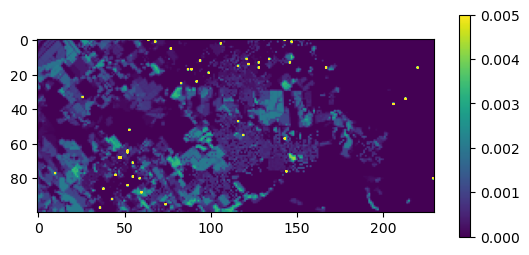

In [17]:
# plt.imshow(rech.mean(axis=0), vmax=0.001)
plt.imshow(pump_rate.mean(axis=0), vmax=0.005)

plt.colorbar(shrink=0.6)

In [ ]:
storativity = np.array(pd.read_csv(model_ws+'/input_data/storativity.tsv', delimiter=' ',header=None))
storativity = np.reshape(storativity, (m.dis.nlay, m.dis.nrow, m.dis.ncol))


## Water Budget check

In [18]:
# load summary water budget
wb = pd.read_csv(model_ws+'/flow_budget.txt', delimiter=r'\s+')
# wb = pd.read_csv(loadpth+'/oneto_denier_upscale8x_2014_2018'+'/flow_budget.txt', delimiter=r'\s+')

wb['kstpkper'] = list(zip(wb.STP-1,wb.PER-1))
wb = wb.merge(dt_ref, on='kstpkper').set_index('dt')


In [19]:
wb_cols = wb.columns[wb.columns.str.contains('_IN|_OUT')]
wb_cols = wb_cols[~wb_cols.str.contains('STORAGE')]
wb_out_cols= wb_cols[wb_cols.str.contains('_OUT')]
wb_in_cols = wb_cols[wb_cols.str.contains('_IN')]
# only include columns with values used
wb_out_cols = wb_out_cols[np.sum(wb[wb_out_cols]>0, axis=0).astype(bool)]
wb_in_cols = wb_in_cols[np.sum(wb[wb_in_cols]>0, axis=0).astype(bool)]


In [20]:
wb.WEL_OUT.sum(), wb.RCH_IN.sum()
# wb

(1343205645.61604, 709827668.82055)

C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


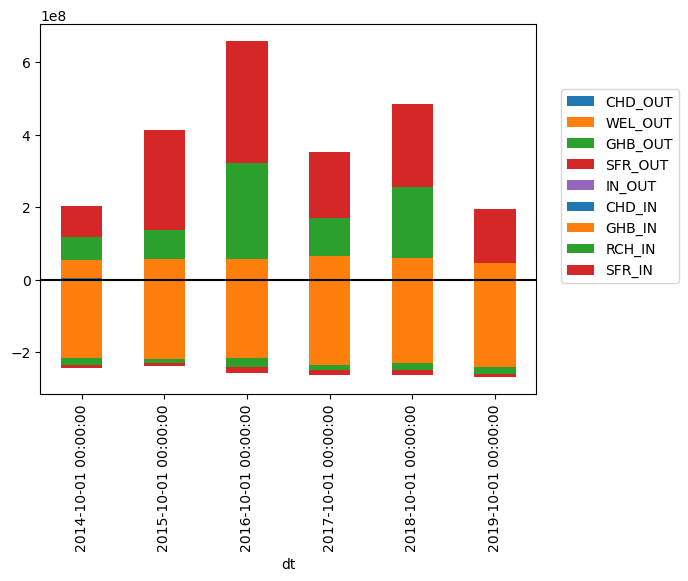

In [21]:
wb_ann = wb.resample('AS-Oct').sum(numeric_only=True)
fig,ax = plt.subplots( sharex=True)
plt.axhline(0, color='black')
wb_ann[wb_out_cols].multiply(-1).plot( kind='bar', ax=ax, stacked=True)
wb_ann[wb_in_cols].plot( kind='bar', ax=ax, stacked=True)
plt.legend(loc=(1.05,0.3))

<Axes: xlabel='dt'>

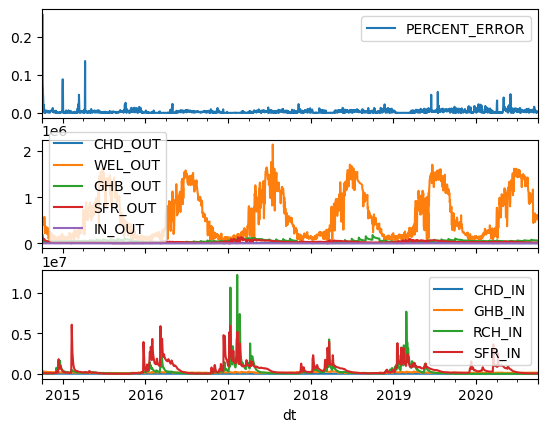

In [22]:
fig,ax= plt.subplots(3,1, sharex=True)
wb.plot(y='PERCENT_ERROR', ax=ax[0])
wb.plot(y=wb_out_cols, ax=ax[1], legend=True)
wb.plot(y=wb_in_cols, ax=ax[2], legend=True)


# Sim vs Obs Head


In [23]:
hobout = pd.read_csv(model_ws+'/MF.hob.out',delimiter=r'\s+', header = 0,names = ['sim_val','WSE','obs_nam'],
                     dtype = {'sim_val':float,'obs_val':float,'obs_nam':object},
                    na_values=[-9999.])
# if only one obs exists correct naming convention
one_obs = ~hobout.obs_nam.str.contains('.0')
hobout.loc[one_obs,'obs_nam'] = hobout.loc[one_obs,'obs_nam']+'.'+str(1).zfill(5)

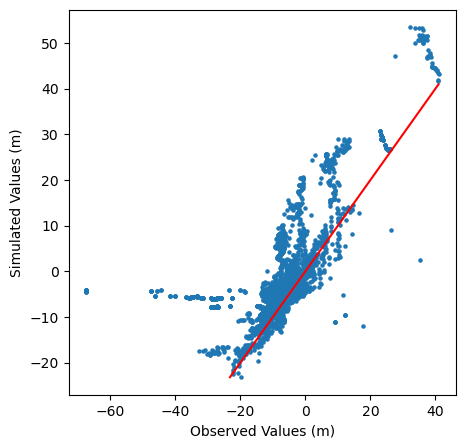

In [24]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

# get boundary values for plotting a 1:1
hobmax = hobout.loc[:,['sim_val','WSE']].max().min()
hobmin = hobout.loc[:,['sim_val','WSE']].min().max()

# plot observed vs simulated values
hobout.plot.scatter(x='WSE', y='sim_val',marker='.',ax=ax)
ax.plot([hobmin,hobmax],[hobmin,hobmax],'red')
ax.set_xlabel('Observed Values (m)')
ax.set_ylabel('Simulated Values (m)')
# plt.xlabel('Observed Values (m)')
# plt.ylabel('Simulated Values (m)')

fig_nam = plt_dir+'GSP_WaterBudget/sim_vs_obs_heads'

# plt.savefig(fig_nam+'.png',dpi=600,bbox_inches='tight')
# plt.savefig(fig_nam+'.svg',dpi=600,bbox_inches='tight')

In [25]:
def mak_hob_gpd(hobout):
    all_obs = pd.read_csv(model_ws+'/input_data/all_obs_grid_prepared.csv',index_col=0)
    all_obs.index = all_obs.index.rename('date')
    all_obs = all_obs.reset_index()
    # join more indepth obs data to output simulated heads
    obs_data = hobout.join(all_obs.set_index('obs_nam'),on=['obs_nam'])
    obs_data = obs_data.dropna(subset=['node'])
#     obs_data.loc[:,['row','column','node']] = obs_data.loc[:,['row','column','node']].astype(int)
    obs_data[['row','column','node']] = obs_data[['row','column','node']].astype(int)
    
    # obs_data.index = obs_data.index
    obs_grid = obs_data.join(grid_p.set_index(['row','column']).loc[:,['easting','northing']], 
                             on=['row','column'])
    # # convert back to geospatial
    hob_gpd = gpd.GeoDataFrame(obs_grid, geometry = gpd.points_from_xy(obs_grid.easting, obs_grid.northing),
                              crs = grid_p.crs)
    hob_gpd['error'] = hob_gpd.WSE - hob_gpd.sim_val
    hob_gpd['abs_error'] = hob_gpd.error.abs()
    
    if 'date' in hob_gpd.columns:
        hob_gpd = hob_gpd.set_index('date')
        hob_gpd.index = pd.to_datetime(hob_gpd.index)    
        #     groupby values by season
        hob_gpd.loc[(hob_gpd.index.month > 2)&(hob_gpd.index.month < 6),'season'] = 'spring'
        hob_gpd.loc[(hob_gpd.index.month > 8)&(hob_gpd.index.month < 12),'season'] = 'fall'
    
    return(hob_gpd)
    # set date
    


In [26]:
hob_gpd = mak_hob_gpd(hobout)

hob_seasonal = hob_gpd.groupby(['node','season']).mean(numeric_only=True)
hob_seasonal = gpd.GeoDataFrame(hob_seasonal, geometry = gpd.points_from_xy(hob_seasonal.easting, hob_seasonal.northing))
hob_seasonal = hob_seasonal.reset_index()
    


In [27]:
stns = hob_gpd.drop_duplicates('site_code', keep='last').reset_index().drop(columns=['date','gwe'])
stns['botm_elev'] = m.dis.botm[stns.layer-1, stns.row-1, stns.column-1]
stns.crs = hob_gpd.crs

In [28]:
hob_gpd['Statistic'] = 0.01
hob_gpd['StatFlag'] = 'SD'
# locations with significant difference between RPE GSE and the DEM should have additional uncertainty included
hob_gpd['Statistic'] += np.round(np.abs(hob_gpd.dem_wlm_gse),4)
hob_gpd['Weight'] = 1/(hob_gpd.Statistic**2)

soswr = (np.sum(np.abs(hob_gpd.sim_val-hob_gpd.WSE)*hob_gpd.Weight))
print('Sum of absolute difference of OBS and SIM: %.2e' %soswr)

Sum of absolute difference of OBS and SIM: 5.47e+05


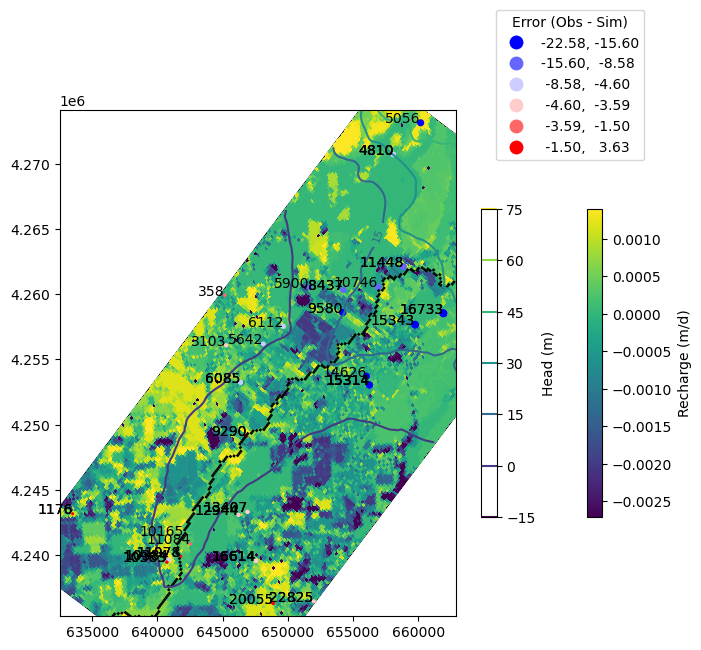

In [29]:
def plt_hob_map(y, s, nd_chk=None):
    fig,ax=plt.subplots(figsize=(8, 8))
    m_domain.plot(ax=ax,color='None')
    mapview = flopy.plot.PlotMapView(model=m,ax=ax)
#     csa = mapview.plot_array(gel.hk.array[1,:,:], norm=mpl.colors.LogNorm())
#     cb = plt.colorbar(csa, shrink=0.5,ax=ax)
#     cb.set_label('Horiz. Cond. (m/d)')

#     csa = mapview.plot_array(-pump_rate.mean(axis=0), vmin=-np.quantile(pump_rate, .95))
    csa = mapview.plot_array(rech.mean(axis=0)- pump_rate.mean(axis=0), vmin=-np.quantile(pump_rate, .95))
    cb = plt.colorbar(csa, shrink=0.5,ax=ax)
    cb.set_label('Recharge (m/d)')

    hob_gpd_plt = hob_gpd[(hob_gpd.index.year==y)&(hob_gpd.season==s)]

    if nd_chk != None:
        hob_gpd_plt = hob_gpd_plt[hob_gpd_plt.node.isin(nd_chk)]
    # hob_gpd.plot('error',scheme='EqualInterval', k= 6, ax=ax,legend=True,cmap='magma')
    hob_gpd_plt.plot('error',markersize='abs_error',scheme='Quantiles', k = 6, ax=ax,
                      legend=True,cmap='bwr',legend_kwds={'loc':(1.1,0.9),'title':'Error (Obs - Sim)'})
    hob_gpd_plt.apply(lambda x: ax.annotate(str(x.node), xy=(x.geometry.x, x.geometry.y), ha='right'),axis=1);
    # stns[stns.botm_elev > stns.screen_elev].plot(color='red',marker='x',ax=ax)
    grid_sfr.plot(ax=ax,color='black')
    contour_set = mapview.contour_array(hdobj.get_data((0,int(hob_gpd_plt.spd.mean()))),
                                masked_values=[-999.99],  ax=ax)
    hcb = plt.colorbar(contour_set, shrink = 0.5,ax=ax)
    hcb.set_label('Head (m)')
    ax.clabel(contour_set, contour_set.levels[0::2], inline=True, fontsize=8)
    gdf_bnds(hob_gpd_plt, ax=ax, buf=1E3)
    return(hob_gpd_plt)

    # ax.legend(loc=(1,0.5))
hob_gpd_plt = plt_hob_map(2019, 'fall')

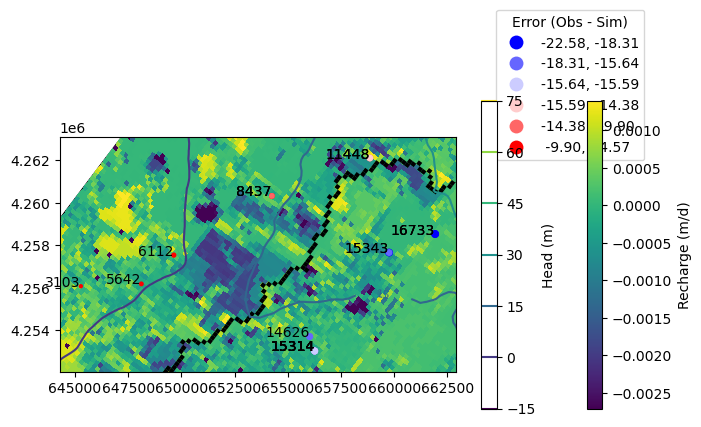

In [33]:
nd_chk = [15343, 16733, 11448, 8437, 15314, 14626] +[3103, 5642, 6112]
hob_gpd_chk = plt_hob_map(2019, 'fall', nd_chk=nd_chk)


In [34]:
df_chk = hob_gpd_chk.groupby('node').mean(numeric_only=True)
df_chk[['sim_val','WSE','well_depth','avg_screen_depth', 'layer','abs_error']]

,sim_val,WSE,well_depth,avg_screen_depth,layer,abs_error
node,,,,,,
3103,-3.422476,-7.991900,NaN,81.0768,17.0,4.569424
5642,-0.642213,-7.168900,64.0080,60.8076,11.0,6.526687
6112,-0.483442,-8.571000,91.4400,86.8680,15.0,8.087558
8437,8.456333,-1.473200,0.0000,0.0000,1.0,9.929533
11448,26.963175,12.588233,41.1480,39.0906,3.0,14.374942
14626,9.465464,-8.458200,54.8640,47.7012,5.0,17.923664
15314,7.732117,-7.865737,88.3920,80.1624,11.0,15.597854
15343,20.363674,1.652050,60.0456,44.0436,2.0,18.711624
16733,25.536308,5.246633,NaN,105.6894,16.0,20.289674


In [32]:
lu_ag = gpd.read_file(join(gwfm_dir, 'UZF_data', 'county_landuse', 'domain_ag_lu_2018.shp'))
lu_ag = gpd.overlay(lu_ag, grid_p)

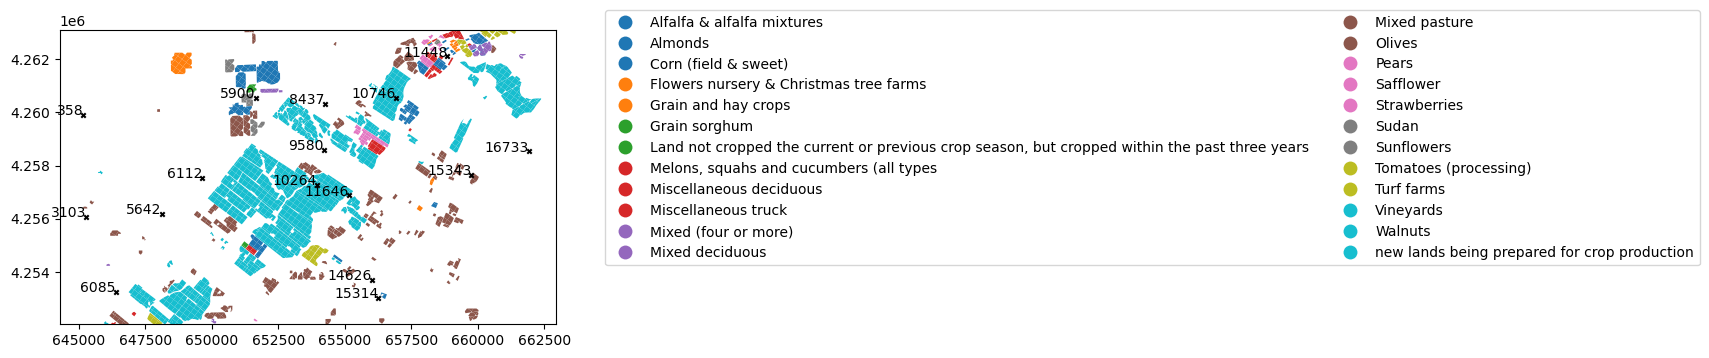

In [35]:
fig, ax = plt.subplots()
gdf_box = gdf_bnds(stns[stns.node.isin(nd_chk)], ax=ax, buf=1E3)

lu_plt = gpd.overlay(lu_ag, gdf_box)
lu_plt = lu_plt[lu_plt.geometry.area > 2*(0.3048**2)*43560] # min 1 acres per type
lu_plt.plot('name',legend=True,ax=ax, legend_kwds={'loc':(1.1,0.2),'ncol':2})
stns.plot(ax=ax, color='black', markersize=10, marker='x')
stns.apply(lambda x: ax.annotate(str(x.node), xy=(x.geometry.x, x.geometry.y), ha='right'),axis=1);


In [154]:
# typical summer drawdown is 2 m at 0.1 Sy is 0.2m of water over a 200m x 200m grid cell
2*0.1*(1/0.3048)

0.6561679790026247

In [37]:
# hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
# spd_stp = hdobj.get_kstpkper()
# times = hdobj.get_times()
# cbc = model_ws+'/MF.cbc'

hobout = pd.read_csv(model_ws+'/MF.hob.out',delimiter=r'\s+', header = 0,names = ['sim_val','WSE','obs_nam'],
                     dtype = {'sim_val':float,'obs_val':float,'obs_nam':object},
                    na_values=[-9999.])
# if only one obs exists correct naming convention
one_obs = ~hobout.obs_nam.str.contains('.0')
hobout.loc[one_obs,'obs_nam'] = hobout.loc[one_obs,'obs_nam']+'.'+str(1).zfill(5)

hob_gpd = mak_hob_gpd(hobout)

# find sites with long time series of OBS
hobs_long = (hob_gpd.groupby('site_code').count()>=int(m.dis.nper/365)*2)
hobs_long = hobs_long.index[hobs_long.WSE].values
# hobs_long.shape
# get layer, row, column for extracting time series head data
hob_kij = hob_gpd.drop_duplicates('node')[['node','layer','row','column']]
hob_kij[['layer','row','column']] -=1
hob_kij['kij'] = list(hob_kij[['layer','row','column']].astype(int).itertuples(index=False,name=None)) #hob_ts


In [30]:
# load times series to check if making changes to hob layer
# hob_ts = pd.DataFrame(hdobj.get_ts(hob_kij.kij.tolist()),columns=np.append(['spd'],hob_kij.node.values)) 
# hob_ts['date'] = strt_date+hob_ts.spd.astype('timedelta64[D]')
# hob_ts = hob_ts.drop(columns='spd')
# ts_long = hob_ts.melt(id_vars='date', var_name='node',value_name='sim_new')
# ts_long.node = ts_long.node.astype(int)
# hob_ts_chk = hob_gpd.join(ts_long.set_index(['date','node']), on=['date','node'],how='left')

In [38]:
# hob_gpd.site_code.unique().shape, voi.shape
import seaborn as sns
hob_long = hob_gpd[hob_gpd.site_code.isin(hobs_long)]
# hob_long = hob_ts_chk.melt(value_vars=['sim_val','WSE', 'sim_new'], id_vars=['site_code'], ignore_index=False)
hob_long = hob_gpd.melt(value_vars=['sim_val','WSE'], id_vars=['node'], ignore_index=False)


In [51]:
chk_lng = hob_long.groupby('node').count().variable
chk_lng = chk_lng[chk_lng>50].index

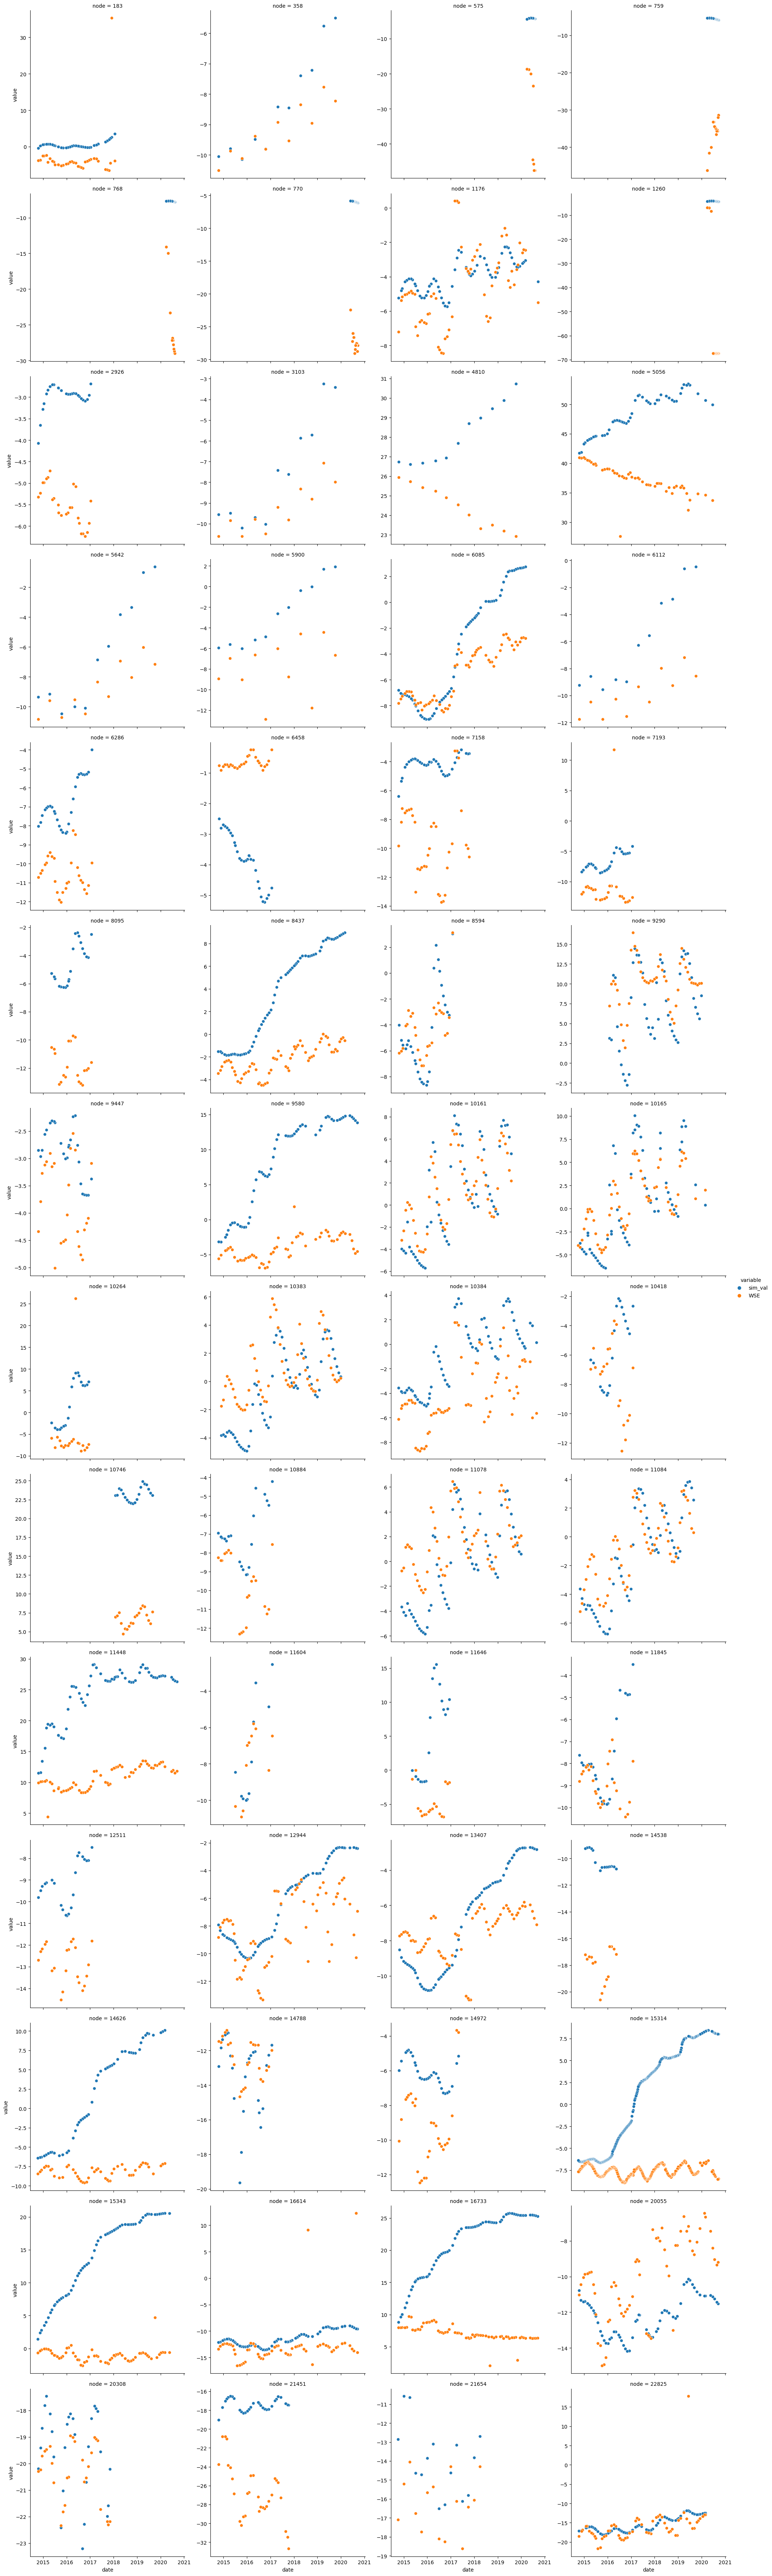

In [53]:
sns.relplot(hob_long, x='date',y='value', 
# sns.relplot(hob_long[hob_long.node.isin(chk_lng)], x='date',y='value', 
            hue='variable', col_wrap=4, col='node',
           facet_kws={'sharex':True, 'sharey':False})

In [342]:

# voi = hob_gpd[hob_gpd.site_code.isin(hobs_long)].node.unique()
# # voi = 22825
# # def obs_sim_node(voi):
# ny = 3
# nx = int(np.ceil(len(voi)/ny))
# fig,ax=plt.subplots(nx,ny,figsize=(12,3*nx))
# for i,voi_n in enumerate(voi):
#     ax_n = ax[int(i / ny), i % ny] if (nx > 1) else ax[i]
#     hob_n = hob_gpd[hob_gpd.node==voi_n]
#     hob_n.reset_index().plot(x='date',y='WSE',kind='scatter', ax=ax_n,
#                                                   marker='x', s=40, legend=False)
#     hob_n.reset_index().plot(x='date',y='sim_val',kind='scatter', ax=ax_n, 
#                                                   marker='o', s=40, legend=False)
#     # add time series of simulated data to see true peaks
# #     ts_i = pd.DataFrame(hdobj.get_ts(hob_kij[hob_kij.node==voi_n].kij.values[0]),columns=['spd','sim_val']) 
#     ts_i['dt'] = dt_ref.dt
#     ts_i.plot(x='dt',y='sim_val', ax=ax_n, legend=False)

#     ax_n.set_xlabel('')
#     ax_n.set_ylabel('')
#     S_n = format(gel.ss.array[hob_n.layer.iloc[0],hob_n.row.iloc[0],hob_n.column.iloc[0]],'.1e')
#     K_n = format(gel.hk.array[hob_n.layer.iloc[0],hob_n.row.iloc[0],hob_n.column.iloc[0]], '.1e')

#     ax_n.set_title(str(voi_n)+' K'+K_n+' S'+S_n+'\n'+hob_n.site_code.iloc[0])
# ax_n.legend(['Observed','Simulated'])
# ax[0,0].legend(['Observed','Simulated'])

# # fig.text(-0.03, 0.2, 'Head (m)',rotation='vertical',size=26)
# # fig.text(0.35, -0.05, 'Date',size=26)
# fig.tight_layout()


In [81]:
# head

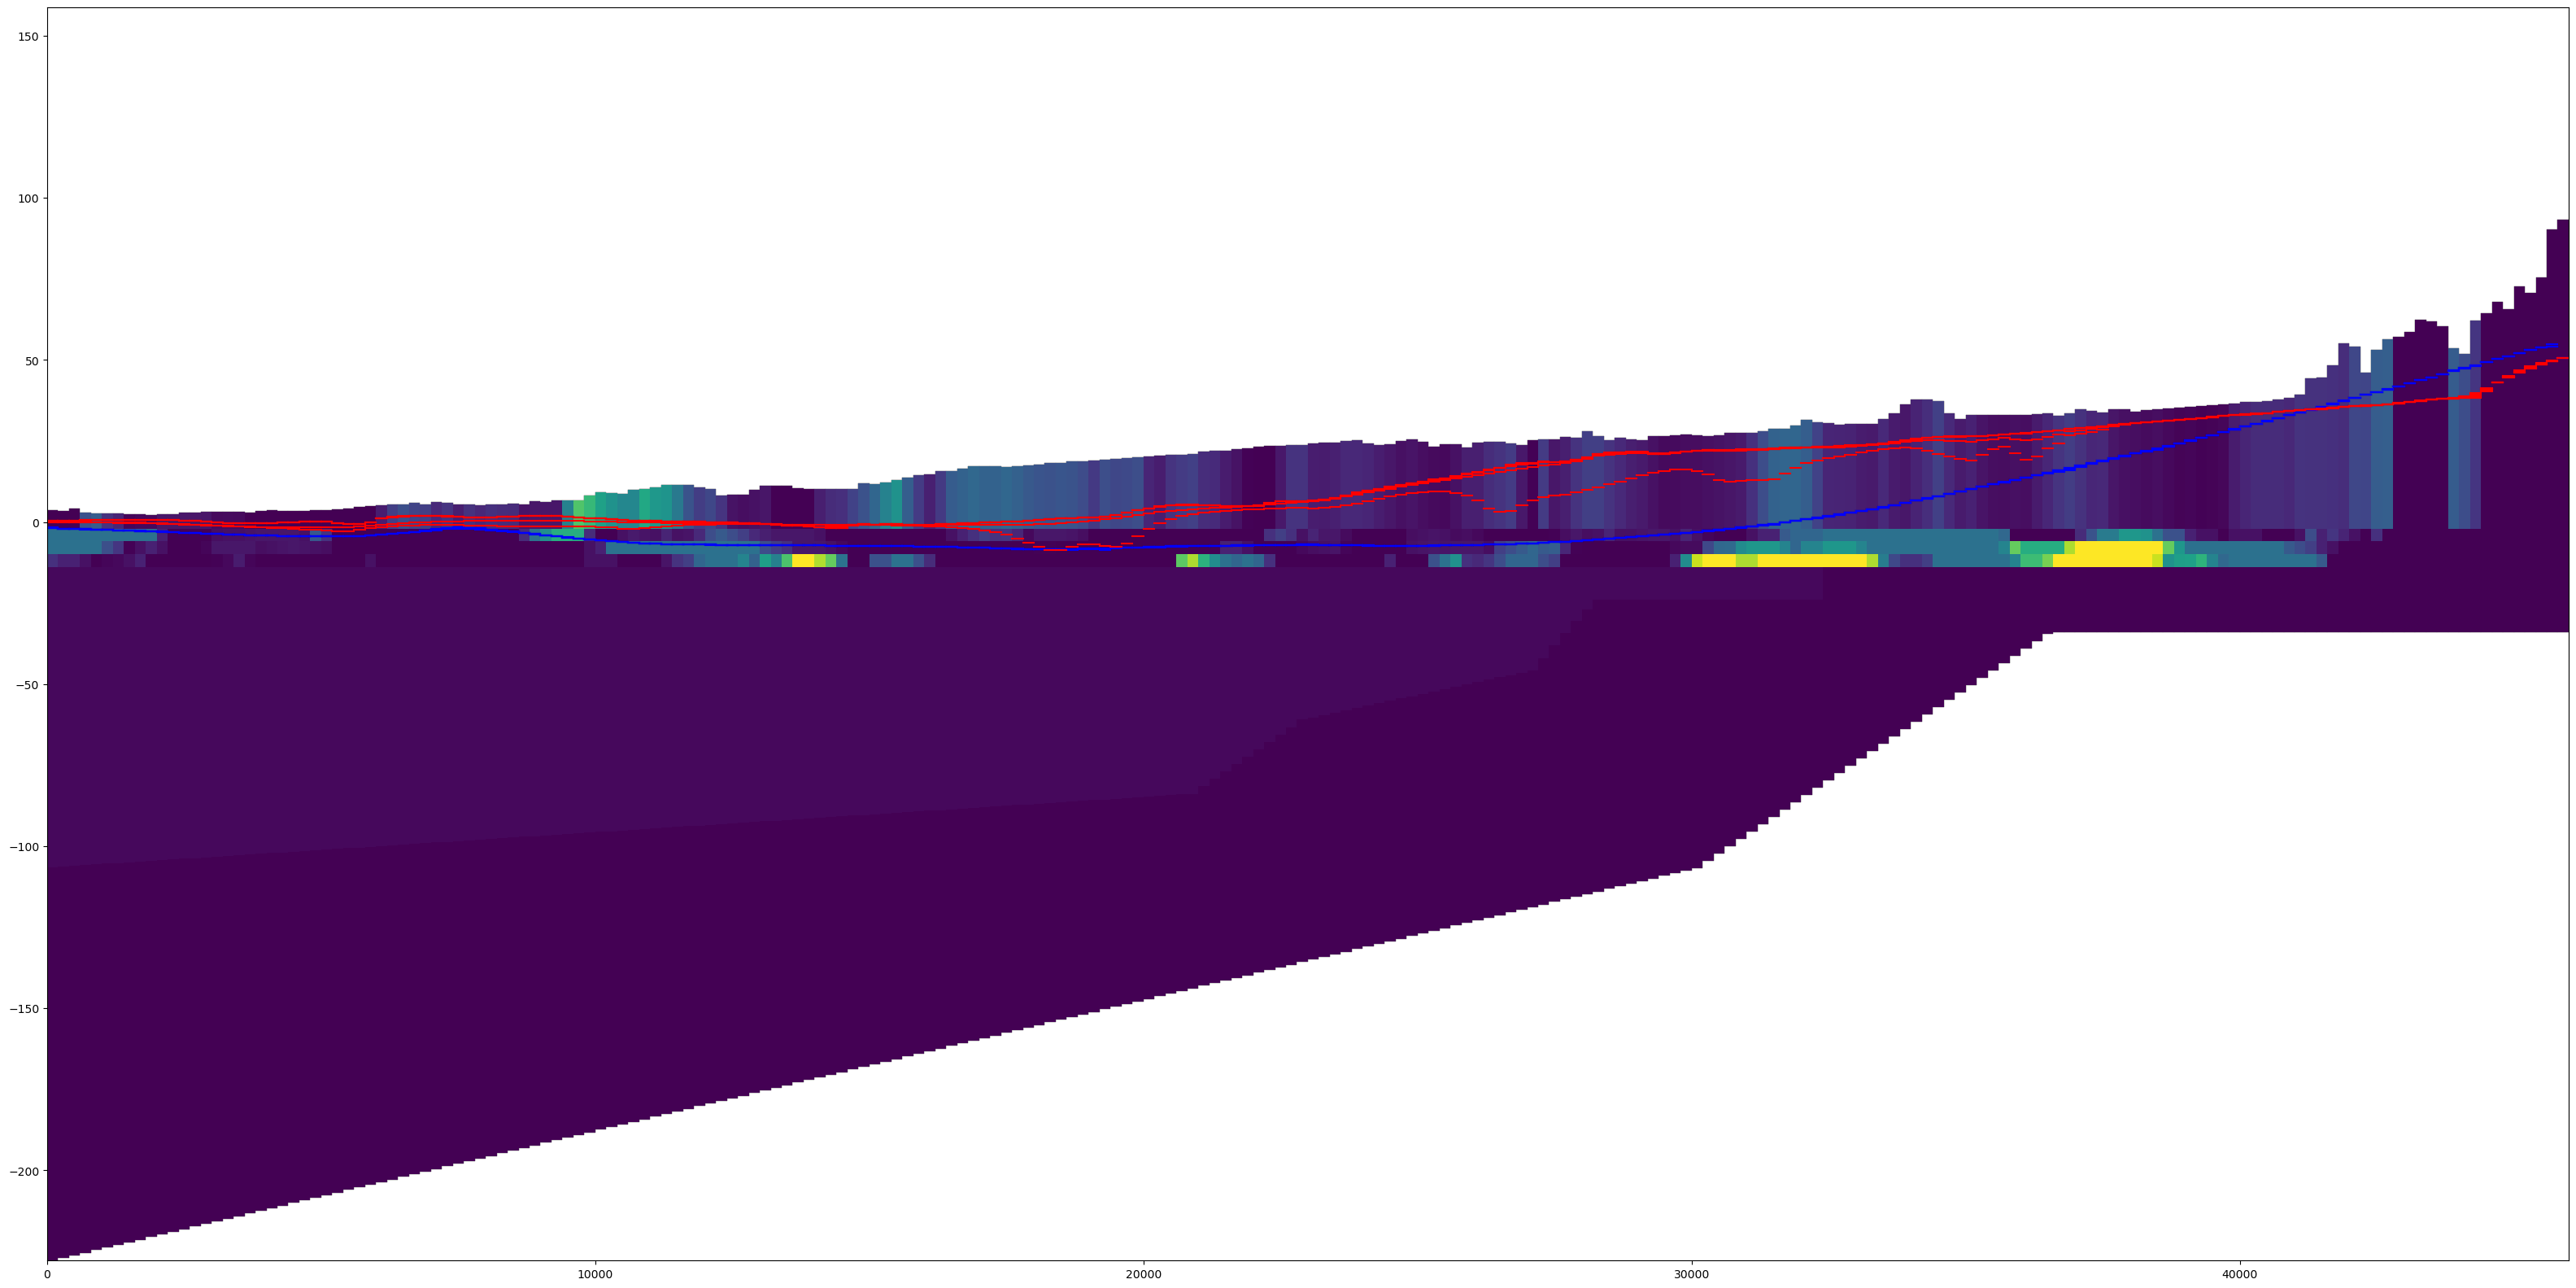

In [33]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(1, 1, 1)

head = hdobj.get_data(kstpkper = spd_stp[0])
head_new = hdobj.get_data(kstpkper = spd_stp[1400])

rownum = 50
# rownum = 0

mcs = flopy.plot.PlotCrossSection(model=m, line={'Row' : rownum})
# colnum = 150
# mcs = flopy.plot.PlotCrossSection(model=m, line={'Column' : colnum})

linecollection = mcs.plot_grid(linewidth = 0.3)
ax.add_collection(linecollection)

mcs.plot_array(a=m.upw.hk.array)

wt = mcs.plot_surface(a=head[:,:,:], color='blue')
wt = mcs.plot_surface(a=head_new[:,:,:],color='red')
